In [1]:
import os
from os import path
from datetime import datetime, timedelta, date
import pytz

from igraph import *

import seaborn as sns
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [2]:
# Various datasets to visualize

option = 12
time0 = time1 = ''
use_new_id_schema = False

if option == 1:
    base_folder = "./simulations/retreat2020"
    sim_id = 29
    sim_tz = "US/Eastern"
    time_step_min = 30
if option == 2:
    base_folder = "./simulations/cmutest"
    sim_id = 32
    sim_tz = "US/Mountain"
    time_step_min = 30
if option == 3:
    base_folder = "./simulations/cmu"
    sim_id = 34
    sim_tz = "US/Mountain"
    time_step_min = 60
if option == 4:
    base_folder = "./simulations/fgcu"
    sim_id = 33
    sim_tz = "US/Eastern"
    time_step_min = 60
if option == 5:
    base_folder = "./simulations/csw1"
    sim_id = 36
    sim_tz = "US/Eastern"
    time_step_min = 60
if option == 6:
    base_folder = "./simulations/csw2"
    sim_id = 37
    sim_tz = "US/Eastern"
    time_step_min = 60
if option == 7:
    base_folder = "./simulations/byu21"
    sim_id = 39
    sim_tz = "US/Mountain"
    time_step_min = 60
if option == 8:
    title = "UCAS21 OO SIMULATION"
    base_folder = "./simulations/ucas21"
    sim_id = 40
    sim_tz = "US/Mountain"
    time_step_min = 60    
if option == 10:
    title = "WALTER JOHNSON HIGH SCHOOL"
    base_folder = "./simulations/wjhs22"
    sim_id = 76
    sim_tz = "US/Eastern"
    time0 = 'Oct 14 2022 7:45AM'
    time1 = 'Oct 14 2022 10:45AM'
    time_step_min = 1
    use_new_id_schema = True
if option == 11:
    title = "ROWAN UNIVERSITY"
    base_folder = "./simulations/rowan22"
    sim_id = 83
    sim_tz = "US/Eastern"
    time0 = 'Nov 7 2022 7:30AM'
    time1 = 'Nov 11 2022 12:30PM'
    time_step_min = 30
    use_new_id_schema = True
    
if option == 12:
    title = "DHS"
    base_folder = "./simulations/dhs22"
    sim_id = 84
    sim_tz = "US/Eastern"
    time0 = 'Nov 29 2022 8:15AM'
    time1 = 'Nov 29 2022 04:15PM'
    time_step_min = 2
    use_new_id_schema = True

In [11]:
# Configuration

# Coded status:
# https://matplotlib.org/3.1.0/gallery/color/named_colors.html
status_color = {0: clr.to_hex("cornflowerblue"),  # Susceptible
                1: clr.to_hex("darkorange"),      # Infected (index case)
                2: clr.to_hex("darkorange"),      # Infected (from someone else)
                3: clr.to_hex("darkgrey"),        # Dead 
                4: clr.to_hex("mediumseagreen"),  # Recovered 
                5: clr.to_hex("darkorchid")       # Vaccinated 
               } 

data_folder = path.join(base_folder, "data")
output_folder = path.join(base_folder, "output")
movie_folder = path.join(output_folder, "movies")
if not path.exists(output_folder):
    os.makedirs(output_folder)
output_sir_folder = path.join(base_folder, "output", "charts", "sir")
if not path.exists(output_sir_folder):
    os.makedirs(output_sir_folder)
output_cont_folder = path.join(base_folder, "output", "charts", "contacts")
if not path.exists(output_cont_folder):
    os.makedirs(output_cont_folder)
output_inf_folder = path.join(base_folder, "output", "charts", "infections")
if not path.exists(output_inf_folder):
    os.makedirs(output_inf_folder)       
if not path.exists(movie_folder):
    os.makedirs(movie_folder)

# Print warning messages to the console when parsing data
print_data_warnings = False
    
# Default contact time for transmissions that are missing an associated contact event
def_contact_time = 10
    
frame_format = "png"

# Time delta for plots in seconds
time_delta_sec = 60 * time_step_min

# This hsould match the corresponding parameter inthe infection and contact animations
# so that the animated charts match with them. But for quick renderings, it should be set to 1.
anim_steps_per_time_delta = 30

# Number of ticks in the x axis of epi plots
num_ticks = 10

# https://howchoo.com/g/ywi5m2vkodk/working-with-datetime-objects-and-timezones-in-python
# https://itnext.io/working-with-timezone-and-python-using-pytz-library-4931e61e5152
timezone = pytz.timezone(sim_tz)

if time0 and time1:
    obs_date0 = timezone.localize(datetime.strptime(time0, '%b %d %Y %I:%M%p'))
    obs_date1 = timezone.localize(datetime.strptime(time1, '%b %d %Y %I:%M%p'))
else:
    obs_date0 = None
    obs_date1 = None

In [4]:
# Some utility functions

def get_contact_list(events, infections):
    contacts = events[events["type"] == "contact"]

    node0 = contacts.user_id.values
    node1 = contacts.peer_id.values
    length = contacts.contact_length.values

    clist = {}
    for id0, id1, l01 in zip(node0, node1, length):
        n0 = user_index[id0]
        if use_new_id_schema:
            if id1 in user_index:
                n1 = user_index[id1]
            elif print_data_warnings:
                print("Cannot find peer", id1)
        else:
            if id1 in p2pToId:
                n1 = user_index[p2pToId[id1]]
            elif print_data_warnings:
                print("Cannot find peer", id1)
    
        if n0 < n1:
            p01 = (n0, n1)
        else:
            p01 = (n1, n0)
        if p01 in clist:
            c = clist[p01]
        else: 
            c = 0

        clist[p01] = c + round(l01 / (60 * 1000))
                        
    # Adding contacts from transmissions if they are not registered as contacts already
    for (n0, n1) in infections:
        if n0 < n1:
            p01 = (n0, n1)
        else:
            p01 = (n1, n0)
        if not p01 in clist:
            clist[p01] = def_contact_time
            if print_data_warnings: print("Cannot find contact between", n0, "and", n1)            

    return clist

def get_infection_list(events):
    infections = events[(events["type"] == "infection")]

    ilist = []
    infected = infections.user_id.values
    peers = infections.inf.values
    for id1, peer0 in zip(infected, peers):
        n1 = user_index[id1]

        if "PEER" in peer0:
            if use_new_id_schema:
                # New schema
                id0 = int(peer0[peer0.index("[") + 1:peer0.index(":")])
                if id0 in user_index:
                    n0 = user_index[id0]
                    if not (n0, n1) in ilist:
                        ilist += [(n0, n1)]
                    elif print_data_warnings:
                        print("Duplicated infection", id0, id1)
                elif print_data_warnings:
                    print("Cannot find peer", id0)

            else:
                # Old schema (sims before 2022): p2p id is in the infection column
                p2p0 = peer0[peer0.index("[") + 1:peer0.index(":")]
                if p2p0 in p2pToId:
                    id0 = p2pToId[p2p0]
                    if id0 in user_index:                        
                        n0 = user_index[id0]
                        if not (n0, n1) in ilist:                        
                            ilist += [(n0, n1)]
                        elif print_data_warnings:
                            print("Duplicated infection", id0, id1)                            
                    elif print_data_warnings:
                        print("Cannot find peer", id0)
            
    return ilist 

def get_node_status(events, status0 = None):    
    if status0 == None:
         status = [0] * len(users)
    else:            
        status = status0

    inf = events[events["type"] == "infection"]
    infMap = pd.Series(inf.inf.values, index=inf.user_id).to_dict()
    for kid in infMap:
        src = infMap[kid]
        idx = user_index[kid]
        if "CASE0" in src:
            status[idx] = 1
        if "PEER" in src:
            status[idx] = 2
            id0 = int(src[5:].split(":")[0])
            idx0 = user_index[id0]       
            if status[idx0] == 0:
                status[idx0] = 1
                if print_data_warnings:
                    print("Infecting peer did not have correct status", idx0)

    out = events[events["type"] == "outcome"]
    outMap = pd.Series(out.out.values, index=out.user_id).to_dict()
    for kid in outMap:
        out = outMap[kid]
        idx = user_index[kid]
        if out == "DEAD":
            status[idx] = 3
        if out == "RECOVERED":
            status[idx] = 4
        if out == "VACCINATED":
            status[idx] = 5
    
    return status

def get_infection_network(infections, status):
    nvert = len(user_index)
    
    g = Graph(directed=True)
    g.add_vertices(nvert)
    g.add_edges(infections)

    if status:
        g.vs["status"] = status
        g.vs["color"] = [status_color[out] for out in g.vs["status"]]
    
    return g

# https://stackoverflow.com/a/48938464
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [5]:
# Load participants and histories

all_users = pd.read_csv(path.join(data_folder, "participants.csv")) 
all_events = pd.read_csv(path.join(data_folder, "histories.csv"))

users = all_users[all_users["sim_id"] == sim_id]

events = all_events[all_events["sim_id"] == sim_id]
events.fillna({'contact_length':0, 'peer_id':-1}, inplace=True)
events["event_start"] = events["time"] - events["contact_length"]/1000
events["event_start"] = events["event_start"].astype(int, errors = 'ignore')
if use_new_id_schema:
    events["peer_id"] = events["peer_id"].astype(int, errors = 'ignore')

p2pToSim = pd.Series(users.sim_id.values, index=users.p2p_id).to_dict()
p2pToId = pd.Series(users.id.values, index=users.p2p_id).to_dict()
idTop2p = pd.Series(users.p2p_id.values, index=users.id).to_dict()
        
user_index = {}
idx = 0
for kid in idTop2p:
    user_index[kid] = idx
    idx += 1

# These should return the same value
print(len(users))
print(len(idTop2p))    
print(len(p2pToId))
print(len(user_index))

86
86
86
86


In [6]:
# Round min and max times to the hour
min_time = min(events['time'])
max_time = max(events['time'])
first_date = hour_rounder(datetime.fromtimestamp(min_time, tz=timezone))
last_date = hour_rounder(datetime.fromtimestamp(max_time, tz=timezone))
min_time = datetime.timestamp(first_date)
max_time = datetime.timestamp(last_date)

print("First event:", first_date)
print("Last event :", last_date)

if time0 and time1:
    print("Start time:", datetime.strptime(time0, '%b %d %Y %I:%M%p'))
    print("End time:", datetime.strptime(time1, '%b %d %Y %I:%M%p'))

print(first_date.tzinfo)

First event: 2022-11-01 10:00:00-04:00
Last event : 2022-11-14 08:00:00-05:00
Start time: 2022-11-07 07:30:00
End time: 2022-11-11 12:30:00
US/Eastern


In [15]:
# Animated charts

frame = 0
tframe = 0
layout0 = None
tstatus = None

if obs_date0 and obs_date1:
    tmin = datetime.timestamp(obs_date0)
    tmax = datetime.timestamp(obs_date1)
    diff_min = (obs_date1 - obs_date0).total_seconds() / 60
else:
    tmin = min_time
    tmax = max_time
    diff_min = (last_date - first_date).total_seconds() / 60

# Calculate label spacing
num_points = diff_min / time_step_min
label_spacing = int(num_points / num_ticks)

nframes = int(((tmax - tmin) / time_delta_sec) * anim_steps_per_time_delta)

series_susceptibles = []
series_infected = []
series_dead = []    
series_recovered = []
series_vaccinated = []
series_contacts = []
series_infections = []
time_index = []
time_ticks = []
tlabels = []

export_susceptibles = []
export_infected = []
export_dead = []    
export_recovered = []
export_vaccinated = []
export_tlabels = []

print("Calculating max number of infections and contacts...", end=" ")
t = tmin
nmaxinf = 0
nmaxcont = 0
while t <= tmax:
    t0 = t    
    t += time_delta_sec
    condition = ((t0 < events['event_start']) & (events['event_start'] <= t)) | ((t0 < events['time']) & (events['time'] <= t))
    tevents = events[condition]
    tinfections = get_infection_list(tevents)
    tcontacts = get_contact_list(tevents, tinfections)
    nmaxinf = max(nmaxinf, len(tinfections))
    nmaxcont = max(nmaxcont, len(tcontacts))    
print("Done")

print("CREATING FRAMES...")
print("FRAME", end =" ")
t = tmin
while t <= tmax:
    t0 = t
    t += time_delta_sec
    td = datetime.fromtimestamp(t, tz=timezone)
        
    # We want to include contact and infection events that either started or ended between t0 and t
    condition = ((t0 < events['event_start']) & (events['event_start'] <= t)) | ((t0 < events['time']) & (events['time'] <= t))
    
    tevents = events[condition]
    tstatus = get_node_status(tevents, tstatus)
    tinfections = get_infection_list(tevents)
    tcontacts = get_contact_list(tevents, tinfections)
    
    nsusceptibles = 0
    ninfected = 0
    ndead = 0    
    nrecovered = 0
    nvaccinated = 0    
    for k in range(0, len(tstatus)):
        if tstatus[k] == 0:
            nsusceptibles += 1
        elif tstatus[k] == 1 or tstatus[k] == 2:
            ninfected += 1  
        elif tstatus[k] == 3:
            ndead += 1
        elif tstatus[k] == 4:
            nrecovered += 1            
        elif tstatus[k] == 5:
            nvaccinated += 1

    ninfections = len(tinfections)            
    ncontacts = len(tcontacts)
            
    ntotal = nsusceptibles + ninfected + ndead + nrecovered + nvaccinated
    # print(nsusceptibles, ninfected, ndead, nrecovered, nvaccinated, ntotal) 

    if tframe % label_spacing == 0:
        tlabels += [td.strftime('%b %d %-I:%M %p')]
        time_ticks += [frame]
    tframe += 1
    
    export_susceptibles.append(nsusceptibles)
    export_infected.append(ninfected)
    export_dead.append(ndead)
    export_recovered.append(nrecovered)
    export_vaccinated.append(nvaccinated)    
    export_tlabels += [td.strftime("%m/%d/%Y %H:%M")]
        
    for i in range(0, anim_steps_per_time_delta):
        print(frame, end =" ")
        series_susceptibles.append(nsusceptibles)
        series_infected.append(ninfected)
        series_dead.append(ndead)
        series_recovered.append(nrecovered)
        series_vaccinated.append(nvaccinated)
        series_contacts.append(ncontacts)
        series_infections.append(ninfections)        
    
        time_index.append(frame)

        # SIR plot
        fig, ax = plt.subplots(figsize=(12,8), facecolor="white")
        plt.ylim([-5, ntotal + 10])
        plt.xlim([-5, nframes + 10])        
        plt.xlabel("Time", labelpad=15, fontsize=15)
        plt.ylabel("Participants", labelpad=15, fontsize=15)
        ax.plot(time_index, series_susceptibles, label="Susceptible", color=status_color[0], lw=2)
        ax.plot(time_index, series_infected, label="Infected", color=status_color[1], lw=2)
        ax.plot(time_index, series_recovered, label="Recovered", color=status_color[4], lw=2)
        ax.plot(time_index, series_vaccinated, label="Vaccinated", color=status_color[5], lw=2)        
        ax.plot(time_index, series_dead, label="Dead", color=status_color[3], lw=2)
        plt.axvline(x=frame, color="dimgray", lw=1)
        plt.xticks(time_ticks, tlabels, rotation=45, horizontalalignment="right")
        plt.legend(loc='upper right')
        plt.tight_layout()
        img_title = td.strftime('%B %d, %I:%M %p')
        img_fn = "frame-" + str(frame) + "." + frame_format
        fig.savefig(os.path.join(output_sir_folder, img_fn))
        plt.close('all')
        
        # Contacts plot
        fig, ax = plt.subplots(figsize=(12,8), facecolor="white")
        plt.ylim([-5, nmaxcont + 10])
        plt.xlim([-5, nframes + 10])        
        plt.xlabel("Time", labelpad=15, fontsize=15)
        plt.ylabel("Number of contacts", labelpad=15, fontsize=15)
        ax.plot(time_index, series_contacts, color="black", lw=2)
        plt.axvline(x=frame, color="dimgray", lw=1)
        plt.xticks(time_ticks, tlabels, rotation=45, horizontalalignment="right")
        plt.tight_layout()
        img_title = td.strftime('%B %d, %I:%M %p')
        img_fn = "frame-" + str(frame) + "." + frame_format
        fig.savefig(os.path.join(output_cont_folder, img_fn))
        plt.close('all')
        
        # Infections plot
        fig, ax = plt.subplots(figsize=(12,8), facecolor="white")
        plt.ylim([-5, nmaxinf + 10])
        plt.xlim([-5, nframes + 10])        
        plt.xlabel("Time", labelpad=15, fontsize=15)
        plt.ylabel("Number of infections", labelpad=15, fontsize=15)
        ax.plot(time_index, series_infections, color=status_color[1], lw=2)
        plt.axvline(x=frame, color="dimgray", lw=1)
        plt.xticks(time_ticks, tlabels, rotation=45, horizontalalignment="right")
        plt.tight_layout()
        img_title = td.strftime('%B %d, %I:%M %p')
        img_fn = "frame-" + str(frame) + "." + frame_format
        fig.savefig(os.path.join(output_inf_folder, img_fn))
        plt.close('all') 

        frame += 1

print("\nDONE")

# Saving data file
df = pd.DataFrame({"Time": export_tlabels,                    
                   "Susceptible": export_susceptibles, "Infected": export_infected, "Dead": export_dead, "Recovered": export_recovered, "Vaccinated": export_vaccinated})
df.to_excel(os.path.join(output_folder, "epi-data.xlsx"), index=False)

Calculating max number of infections and contacts... Done
CREATING FRAMES...
FRAME 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256

In [16]:
print("CREATING THE MOVIE FILES...")

def make_movie(in_folder, out_folder, fn):
    movie_fn = path.join(out_folder, fn)
    if path.exists(movie_fn):
        os.remove(movie_fn)
    cmd_str = "ffmpeg -i " + in_folder + "/frame-%d.png -c:v libx264 -pix_fmt yuv420p " + out_folder + "/" + fn
    os.system(cmd_str)

make_movie(output_sir_folder, movie_folder, "counts-sir.mp4")
make_movie(output_cont_folder, movie_folder, "counts-cont.mp4")
make_movie(output_inf_folder, movie_folder, "counts-inf.mp4")

print("DONE")

CREATING THE MOVIE FILES...


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.102)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolbox


DONE


frame= 6090 fps=950 q=-1.0 Lsize=     497kB time=00:04:03.48 bitrate=  16.7kbits/s speed=  38x    
video:424kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 16.993568%
[libx264 @ 0x7ff352807d40] frame I:25    Avg QP:13.59  size:  6895
[libx264 @ 0x7ff352807d40] frame P:1535  Avg QP:11.97  size:    68
[libx264 @ 0x7ff352807d40] frame B:4530  Avg QP:12.71  size:    35
[libx264 @ 0x7ff352807d40] consecutive B-frames:  0.8%  0.0%  0.0% 99.2%
[libx264 @ 0x7ff352807d40] mb I  I16..4: 51.0% 42.5%  6.5%
[libx264 @ 0x7ff352807d40] mb P  I16..4:  0.3%  0.0%  0.0%  P16..4:  1.1%  0.0%  0.0%  0.0%  0.0%    skip:98.6%
[libx264 @ 0x7ff352807d40] mb B  I16..4:  0.0%  0.0%  0.0%  B16..8:  0.6%  0.0%  0.0%  direct: 0.0%  skip:99.4%  L0:50.2% L1:49.8% BI: 0.0%
[libx264 @ 0x7ff352807d40] 8x8 transform intra:35.4% inter:6.2%
[libx264 @ 0x7ff352807d40] coded y,uvDC,uvAC intra: 3.2% 0.4% 0.3% inter: 0.0% 0.0% 0.0%
[libx264 @ 0x7ff352807d40] i16 v,h,dc,p: 85% 14%  1%  0%
[libx2

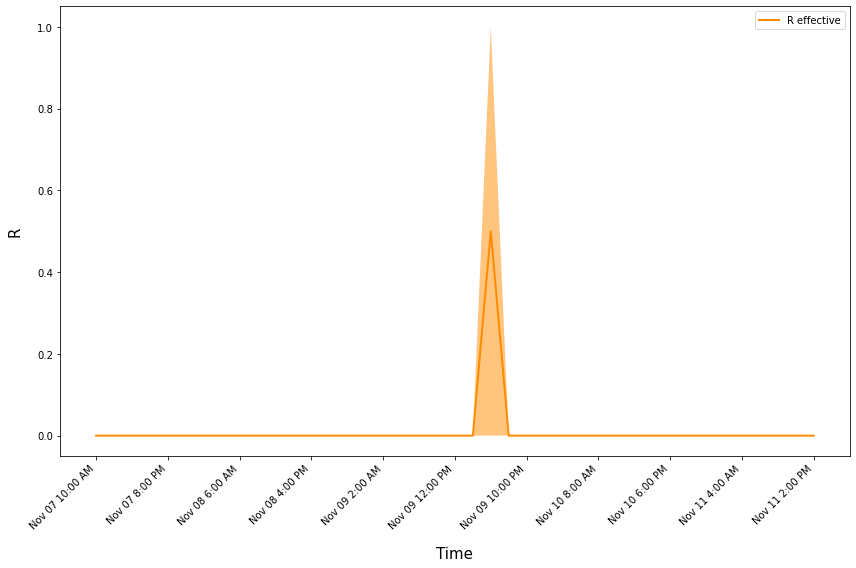

In [9]:
# R effective over time

# Might need a scaling larger than 1 to capture more events for an accurate estimation of Reff
scale = 5

delta = time_delta_sec * scale
spacing = int(label_spacing / scale)

frame = 0
layout0 = None
tstatus = None

if obs_date0 and obs_date1:
    tmin = datetime.timestamp(obs_date0)
    tmax = datetime.timestamp(obs_date1)
else:
    tmin = min_time
    tmax = max_time

t = tmin
r_mean_values = []
r_std_values = []
tlabels = []
time_ticks = []
index = []
while t <= tmax:
    t0 = t
    t += delta
    td = datetime.fromtimestamp(t, tz=timezone)    

    # We want to include contact and infection events that either started or ended between t0 and t
    condition = ((t0 < events['event_start']) & (events['event_start'] <= t)) | ((t0 < events['time']) & (events['time'] <= t))
    
    tevents = events[condition]
    tstatus = get_node_status(tevents, tstatus)
    tinfections = get_infection_list(tevents)
    g = get_infection_network(tinfections, tstatus)
    
    # Getting all nodes with at least one edge
    r_values = []    
    sel = g.vs(_degree_gt=0)

    for v in sel:
        nout = v.degree(mode=OUT)
        r_values += [nout]

    if r_values:
        r_mean = np.mean(r_values)
        r_std = np.std(r_values)
        r_mean_values += [r_mean]
        r_std_values += [r_std]
    else:
        r_mean_values += [0]
        r_std_values += [0]
        
    if frame % spacing == 0: 
        tlabels += [td.strftime('%b %d %-I:%M %p')]
        time_ticks += [frame]
    time_index += [frame]
    frame += 1

mu = np.array(r_mean_values)
sigma = np.array(r_std_values)
time = np.arange(len(sigma))
    
fig, ax = plt.subplots(figsize=(12,8))
plt.xlabel("Time", labelpad=15, fontsize=15)
plt.ylabel("R", labelpad=15, fontsize=15)
ax.plot(time, mu, lw=2, label='R effective', color='darkorange')
ax.fill_between(time, mu+sigma, mu-sigma, facecolor='darkorange', alpha=0.5)

plt.xticks(time_ticks, tlabels, rotation=45, horizontalalignment="right")

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(output_folder, "r-effective.pdf"))

0.5 0.5


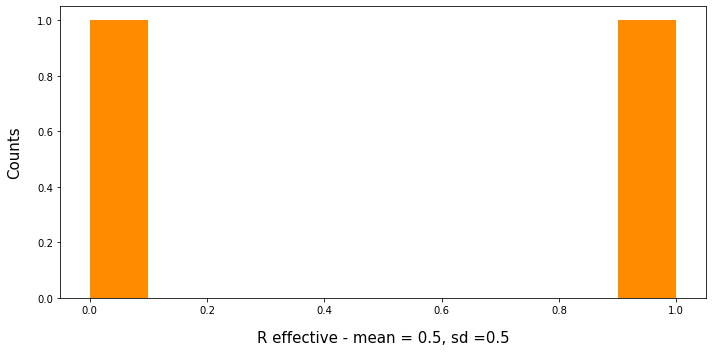

In [10]:
# Plot distribution of R averaged over the entire simulation

status = get_node_status(events)
infections = get_infection_list(events)
g = get_infection_network(infections, status)

r_values = []    
sel = g.vs(_degree_gt=0)
for v in sel:
    nout = v.degree(mode=OUT)
    r_values += [nout]

r_mean = np.mean(r_values)
r_std = np.std(r_values)
counts, bins = np.histogram(r_values)

print(r_mean, r_std)

fig, ax = plt.subplots(figsize=(10,5))
plt.ylabel("Counts", labelpad=15, fontsize=15)
plt.xlabel("R effective - mean = " + str(round(r_mean, 2)) + ", sd =" + str(round(r_std, 2)), labelpad=15, fontsize=15)
plt.hist(bins[:-1], bins, color="darkorange", weights=counts)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "r-mean-histogram.pdf"))